### Charmi Shah
# Overview
### Summary - Gender Classifier for Zylu Business Solutions
* Base model: ResNet152V2 with imagenet weights
* Transfer learning in two different ways:  
 A. One-step transfer learning without freezing the base layer  
 B. Two-step transfer learning (first only the output layer, then fine-tuning)
* Got a 87-88% test accuracy with (B) way of transfer learning

### Contents
1. [Imports](#1)
2. [Load data](#2)
3. [Clean-up data](#3)
  - [Helper functions](#3.1)
  - [Preview images](#3.2)
  - [Image size analysis](#3.3)
  - [Balance the dataset](#3.4)
4. [Split the data](#4)
5. [Prepare data](#5)
6. [Models](#6)
  - [Transfer learning in one-step (ie. the unfrozen model)](#6.1)
  - [Transfer learning + fine-tuning (ie. the frozen model)](#6.2)
7. [Training](#7)
  - [Settings & configs & helpers](#7.0)
  - [One-step transfer learning (with unfrozen base)](#7.1)
  - [Two-step transfer learning](#7.2)
    - [Step1: Training the output layer](#7.2.1)
    - [Step2: Fine-tuning](#7.2.2)
8. [Examples of correct and incorrect predictions](#8)
9. [Conclusions](#9)

<a id="1"></a>
# 1. Imports + random seeds

In [2]:
import os
# os.environ['PYTHONHASHSEED']=str(SEED)

import random
# random.seed(SEED)

import numpy as np
# np.random.seed(SEED)

import tensorflow as tf
# tf.random.set_seed(SEED)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import cv2
import math
import glob
from PIL import Image
from collections import Counter

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# supress tf warnings:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
# supress pd warnings:
pd.options.mode.chained_assignment = None  # default='warn'

<a id="2"></a>
# 2. Load data

In [4]:
# create an empty dataframe
df_raw  = pd.DataFrame()
women_df=pd.DataFrame()
men_df=pd.DataFrame()

In [6]:
men = glob.glob(r"C:\Users\CHARMI\Desktop\face_detection\man\*.jpg")
women = glob.glob(r"C:\Users\CHARMI\Desktop\face_detection\women\*.jpg")
men_df = pd.DataFrame({'filepath': men, 'gender': 'man'})
women_df = pd.DataFrame({'filepath': women, 'gender': 'woman'})

df_raw = pd.concat([men_df, women_df], ignore_index=True)

In [7]:
df_raw.shape[0]

175

<a id="3"></a>
# 3. Clean-up data

<a id="3.1"></a>
## 3.1. Helper functions

In [9]:
def show_images(df, n=10, sample=False, start_row=0, preds=[]):
    df = df[start_row:]
    n = min(df.shape[0], n)
    n_rows = math.ceil(n/5)
    df = df.sample(n) if sample else df.head(n)

    fig = plt.figure(figsize=(20, 4*n_rows))

    for i, (img_index, row) in enumerate(df.iterrows()):
        optional_prediction = "\n"
        if 'prediction' in row:
            predicted_gender = "man" if row.prediction >= 0.5 else "woman"
            certainty = row.prediction if predicted_gender == "man" else 1-row.prediction
            optional_prediction += f"Prediction: {predicted_gender} - {certainty:.1%}"
        title = f"ID:{img_index} {row.gender}{optional_prediction}"
        image = mpimg.imread(row["filepath"])
        fig.add_subplot(n_rows, 5, i+1)
        plt.title(title)
        plt.imshow(image)
        plt.axis(False)
    plt.show()

<a id="3.2"></a>
## 3.2. Preview images

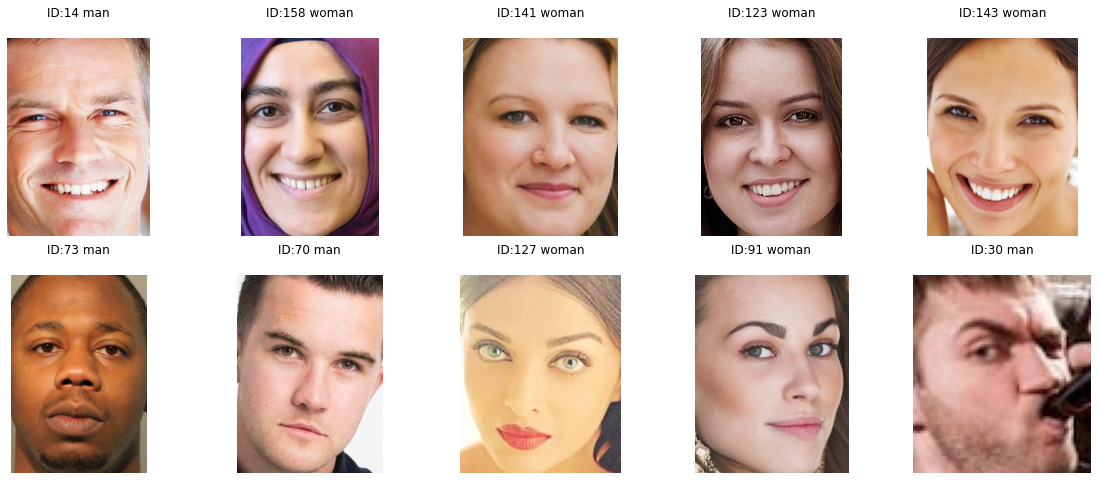

In [10]:
show_images(df_raw, sample=True)

In [12]:
# Let's copy the original dataframe and work over it for backup purpose
df = df_raw.copy()


<a id="3.4"></a>
## 3.3. Image size analysis ( filtering out small images )

<BarContainer object of 5 artists>

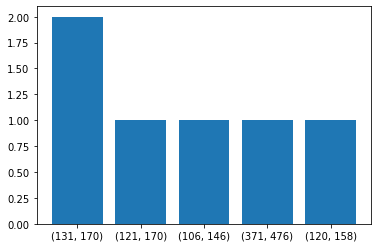

In [13]:
sizes = [Image.open(filepath).size for filepath in df["filepath"]]
df["size"] = sizes
d = Counter(sizes).most_common()[:5]
d = [(str(k),v) for k,v in d]
plt.bar(*list(map(list, zip(*d))))

<a id="3.5"></a>
## 3.4. Balance the dataset

It's fair to expect that in real application the ratio of men and women is about the same. Therefore let's balance the amount of men and women in the dataset.

<AxesSubplot:>

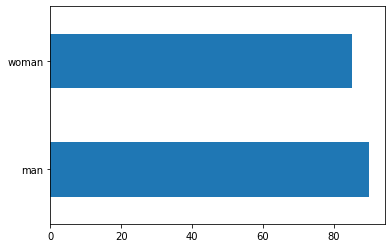

In [14]:
# Inspect the data balance
df.gender.value_counts().plot(kind='barh')
# df_big_images.gender.value_counts().plot(kind='barh')

In [15]:
# There are way more men in the images. Let's make the groups balanced:
# df = df_big_images.copy()
df = df.groupby('gender')
df = df.apply(lambda x: x.sample(df.size().min())).reset_index(drop=True)
df.gender.value_counts()

man      85
woman    85
Name: gender, dtype: int64

<a id="4"></a>
# 4. Split the data

In [16]:
train_df, valid_test_df = train_test_split(df, train_size=0.7,stratify=df['gender'], random_state=SEED)
valid_df, test_df = train_test_split(valid_test_df, train_size=0.5, stratify=valid_test_df['gender'], random_state=SEED)
print('train_df', train_df.gender.value_counts().to_dict())
print('valid_df', valid_df.gender.value_counts().to_dict())
print('test_df', test_df.gender.value_counts().to_dict())

train_df {'man': 59, 'woman': 59}
valid_df {'woman': 13, 'man': 13}
test_df {'woman': 13, 'man': 13}


<a id="5"></a>
# 5. Prepare data

In [17]:
img_dim = 224 # preferred input shape for ResNet152V2 is (224,224,3)
input_shape = (img_dim, img_dim, 3)
img_size = (img_dim, img_dim)
batch_size = 50

img_augmentations = {
    "horizontal_flip": True,
    "rotation_range": 10,
    "width_shift_range": 0.05,
    "height_shift_range": 0.05
}

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_augmentations)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepath', y_col='gender', target_size=img_size,
                                              class_mode='binary', shuffle=True, batch_size=batch_size)
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col='filepath', y_col='gender', target_size=img_size,
                                             class_mode='binary', shuffle=False, batch_size=batch_size)
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filepath', y_col='gender', target_size=img_size,
                                            class_mode='binary', shuffle=False, batch_size=batch_size)

Found 118 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


<a id="6"></a>
# 6. Models

Transfer learning and fine-tuning with ResNet152V2.  
Let's train it in two different ways:
1. Transfer learning the whole model without freezing the base (model.trainable = True)
2. Transfer learning + fine-tuning in two steps:  
  a. First, let's freeze base model and train the top (ie. the classifier)  
  b. Then, let's unfreeze the base model and fine-tune its parameters

<a id="6.1"></a>
## 6.1. Transfer learning in one-step (ie. the unfrozen model)

In [18]:
# Unfrozen model
# Base:
base_model1 = ResNet152V2(include_top=False, weights="imagenet", pooling='avg', input_shape=input_shape)

# Top:
output_model1 = Sequential()
output_model1.add(BatchNormalization())
output_model1.add(Dense(64, kernel_regularizer=regularizers.l2(l2=0.02), activation='relu'))
output_model1.add(Dropout(rate=.3, seed=SEED))
output_model1.add(BatchNormalization())
output_model1.add(Dense(64, kernel_regularizer=regularizers.l2(l2=0.02), activation='relu'))
output_model1.add(Dropout(rate=.5, seed=SEED))
output_model1.add(Dense(1, activation='sigmoid'))
output1 = output_model1(base_model1.output)

# Model:
unfrozen_model = Model(inputs=base_model1.input, outputs=output1)
unfrozen_model.compile(Adamax(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy']) 

<a id="6.2"></a>
## 6.2. Transfer learning + fine-tuning (ie. the frozen model)

In [22]:
# Frozen model
# Base:
base_model2 = ResNet152V2(include_top=False, weights="imagenet", pooling='avg', input_shape=input_shape)
base_model2.trainable = False # Let's first train the top
base_model_output2 = base_model2(base_model2.input, training=False) # Inference mode

# Top:
output_model2 = Sequential()
output_model2.add(BatchNormalization())
output_model2.add(Dense(64, kernel_regularizer=regularizers.l2(l2=0.02), activation='relu'))
output_model2.add(Dropout(rate=.3, seed=SEED))
output_model2.add(BatchNormalization())
output_model2.add(Dense(64, kernel_regularizer=regularizers.l2(l2=0.02), activation='relu'))
output_model2.add(Dropout(rate=.5, seed=SEED))
output_model2.add(Dense(1, activation='sigmoid'))
output2 = output_model2(base_model2.output)

# Model:
frozen_model = Model(inputs=base_model2.input, outputs=output2)
frozen_model.compile(Adamax(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])

<a id="7"></a>
# 7. Training

<a id="7.0"></a>
## 7.0. Settings & configs & helpers

In [23]:
epochs = 20 # just in case... Early stopping will most likely stop the training earlier

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, min_lr=0.00001, verbose=1)
callbacks = [early_stopping]
# reduce_lr

def get_test_results(model, generator):
    acc = model.evaluate(generator)[1]*100
    preds = model.predict(generator)
    pred_values = [np.round(p[0]) for p in preds]
    true_values = test_gen.labels
    return acc, preds, pred_values, true_values

def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a id="7.1"></a>
## 7.1. One-step transfer learning (with unfrozen base)

Epoch 1/20
3/3 [==============================] - 240s 62s/step - loss: 4.3442 - accuracy: 0.6525 - val_loss: 4.2522 - val_accuracy: 0.6923
Epoch 2/20
3/3 [==============================] - 203s 56s/step - loss: 4.0631 - accuracy: 0.7966 - val_loss: 4.5757 - val_accuracy: 0.5385
Epoch 3/20
3/3 [==============================] - 190s 55s/step - loss: 3.8961 - accuracy: 0.8983 - val_loss: 4.9985 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 8s 8s/step
Test data accuracy: 50.00 %


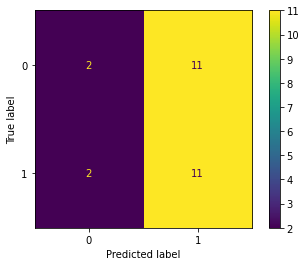

In [20]:
history1 = unfrozen_model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                              validation_data=valid_gen, shuffle=False)

acc1, preds1, pred_values1, true_values1 = get_test_results(unfrozen_model, test_gen)
print(f'Test data accuracy: {acc1:5.2f} %')
conf_matrix1 = confusion_matrix(true_values1, pred_values1)
ConfusionMatrixDisplay(conf_matrix1).plot()

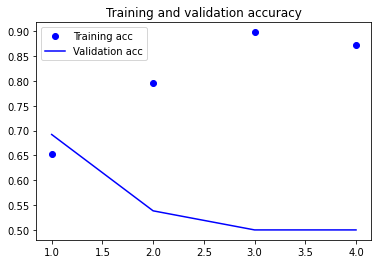

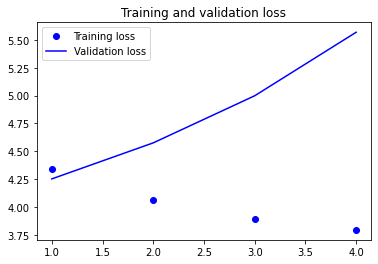

In [21]:
plot_history(history1)

<a id="7.2"></a>
## 7.2. Two-step transfer learning

<a id="7.2.1"></a>
### 7.2.1. Step1: Training the output layer

Epoch 1/20
3/3 [==============================] - 41s 12s/step - loss: 4.5091 - accuracy: 0.6017 - val_loss: 4.2727 - val_accuracy: 0.6923
Epoch 2/20
3/3 [==============================] - 32s 10s/step - loss: 4.3018 - accuracy: 0.6780 - val_loss: 4.1394 - val_accuracy: 0.8077
Epoch 3/20
3/3 [==============================] - 32s 10s/step - loss: 3.9886 - accuracy: 0.7966 - val_loss: 4.0374 - val_accuracy: 0.8462
Epoch 4/20
3/3 [==============================] - 33s 11s/step - loss: 3.9199 - accuracy: 0.8729 - val_loss: 3.9511 - val_accuracy: 0.8462
Epoch 5/20
3/3 [==============================] - 33s 10s/step - loss: 3.8016 - accuracy: 0.8475 - val_loss: 3.8752 - val_accuracy: 0.8846
Epoch 6/20
3/3 [==============================] - 32s 10s/step - loss: 3.7311 - accuracy: 0.8983 - val_loss: 3.8089 - val_accuracy: 0.8846
Epoch 7/20
3/3 [==============================] - 32s 10s/step - loss: 3.6778 - accuracy: 0.8729 - val_loss: 3.7469 - val_accuracy: 0.8846
Epoch 8/20
3/3 [===========

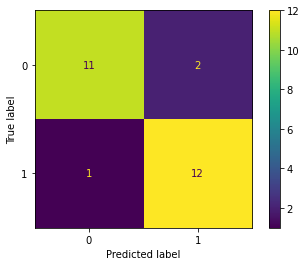

In [24]:
history2a = frozen_model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                             validation_data=valid_gen, shuffle=False)

acc2a, preds2a, pred_values2a, true_values2a = get_test_results(frozen_model, test_gen)
print(f'Test data accuracy: {acc2a:5.2f} %')
conf_matrix2a = confusion_matrix(true_values2a, pred_values2a)
ConfusionMatrixDisplay(conf_matrix2a).plot()

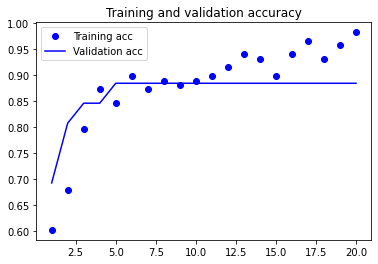

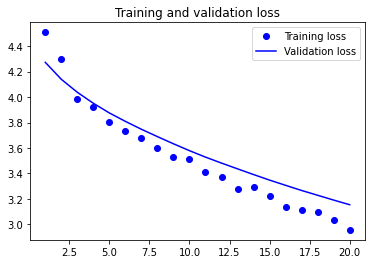

In [25]:
plot_history(history2a)

<a id="7.2.2"></a>
### 7.2.2. Step2: Fine-tuning

Epoch 1/20
3/3 [==============================] - 215s 56s/step - loss: 3.3273 - accuracy: 0.7119 - val_loss: 3.0916 - val_accuracy: 0.8846
Epoch 2/20
3/3 [==============================] - 171s 48s/step - loss: 3.0646 - accuracy: 0.8729 - val_loss: 3.0777 - val_accuracy: 0.8077
Epoch 3/20
3/3 [==============================] - 171s 49s/step - loss: 2.9749 - accuracy: 0.9322 - val_loss: 3.0645 - val_accuracy: 0.8077
Epoch 4/20
3/3 [==============================] - 166s 45s/step - loss: 2.9662 - accuracy: 0.9407 - val_loss: 3.0526 - val_accuracy: 0.8462
Epoch 5/20
3/3 [==============================] - 149s 42s/step - loss: 2.9463 - accuracy: 0.9322 - val_loss: 3.0479 - val_accuracy: 0.8462
Epoch 6/20
3/3 [==============================] - 150s 42s/step - loss: 2.9542 - accuracy: 0.9407 - val_loss: 3.0236 - val_accuracy: 0.8462
Epoch 7/20
3/3 [==============================] - 147s 41s/step - loss: 2.8504 - accuracy: 0.9915 - val_loss: 3.0001 - val_accuracy: 0.8462
Epoch 8/20
3/3 [====

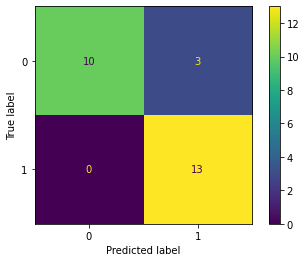

In [26]:
# Let's unfreeze the base and fine-tune it
frozen_model.trainable = True
frozen_model.compile(Adamax(learning_rate=.0002), # Smaller learning rate!!
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
history2b = frozen_model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                             validation_data=valid_gen, shuffle=False)
acc2b, preds2b, pred_values2b, true_values2b = get_test_results(frozen_model, test_gen)
print(f'Test data accuracy: {acc2b:5.2f} %')
conf_matrix2b = confusion_matrix(true_values2b, pred_values2b)
ConfusionMatrixDisplay(conf_matrix2b).plot()

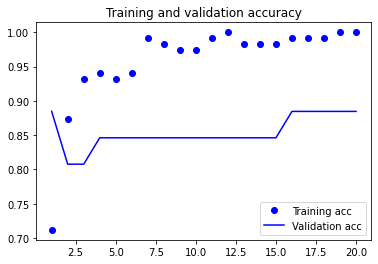

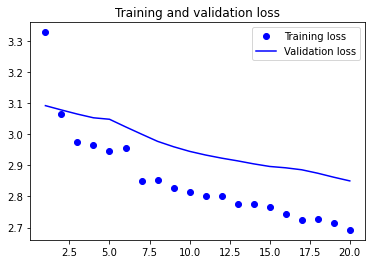

In [27]:
plot_history(history2b)

<a id="8"></a>
# 8. Examples of correct and incorrect predictions

In [31]:
# Preds2b - value obtained after 2 step transfer learning
predicted_values1 = [np.round(p[0]) for p in preds2b] 
true_values1 = test_gen.labels
correct_indexs = []
correct_accuracies = []
wrong_indexs = []
wrong_accuracies = []
for i,pred in enumerate(predicted_values1):
    if pred == true_values1[i]:
        correct_indexs.append(i)
        correct_accuracies.append(1-preds2b[i][0])
    else:
        wrong_indexs.append(i)
        wrong_accuracies.append(1-preds2b[i][0])

### Correctly predicted images

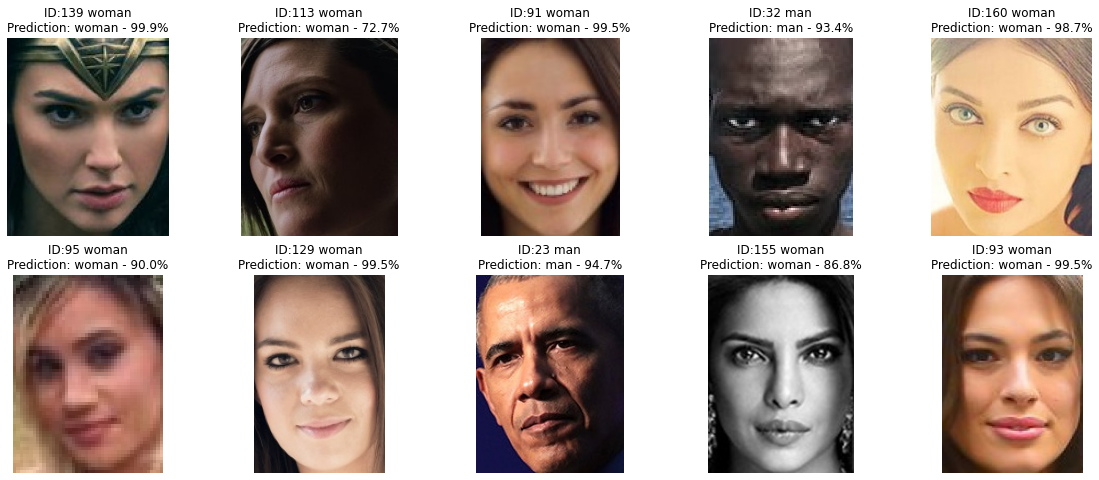

In [32]:
correct_df = test_df.iloc[correct_indexs]
correct_df['prediction'] = correct_accuracies
show_images(correct_df, sample=True, n=10, start_row=0)

### Incorrectly predicted images

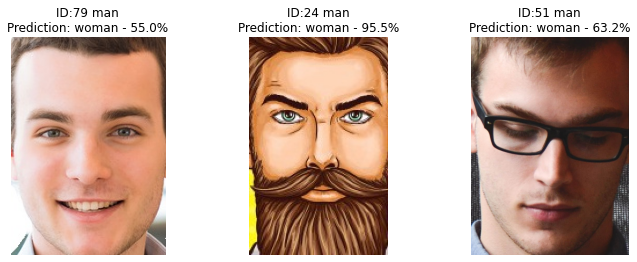

In [33]:
wrong_df = test_df.iloc[wrong_indexs]
wrong_df['prediction'] = wrong_accuracies
show_images(wrong_df, sample=True, n=10, start_row=0)

<a id="9"></a>
# 9. Conclusions
- The overall result was quite satisfactory: 87 - 88 % test accuracy.
- It seems that sometimes one get a major advantage in transfer learning by training the model in two steps (ie. first just the output-layer and then the whole model by fine-tuning with a lower learning rate). Here we in fact got a low accuracy just by training the whole model in one go (Section 7.1). 
- Transfer-learning by training just the output-layer often brings quite similar results! Here we got 87-88 % accuracy! (Section 7.2.1). If possible, always at least fine-tune your model (Section 7.2.2), few times it yields better results
- How to improve the results? Overfitting is always a problem. The accuracy and loss for the train data was better than for validation data. Lots of room for improvement there with just proper regularization!